## Student: Rodolfo Lerma

# Regularization for Neural Network Training

## Machine Learning 530

## Stephen Elston

## 1.0 Why do we need regularization for deep learning?

Deep learning models have a great many parameters (weights) which must be fit. This situation arises from the wide and deep architectures that are required to achieve significant **model capacity** for representing complex functions. The core issue is that over-fit models will simply learn the training data and **over-fit models do not generalize**. Therefore, regularization methods are required in order to prevent over-fitting.

In particular, we can point to three interrelated problems with training deep neural networks:

1. Neural network models have large numbers of parameters (weights). With any finite size data set, there is likely to be a low ratio of cases per parameter or low ratio of cases to features. For example, if we are classifying 512 x 512 images with 1,000,000 training cases there are only about 4 cases per feature. This is why training neural networks often requires massive amounts of data. 
2. As a result of the large numbers of parameters, neural networks are susceptible to noise in the training data. Neural networks are generally considered less robust to noise than shallow machine learning methods. 
3. Presumably as a result of the model complexity, neural networks often return unexpected predictions for data cases outside the training data domain. This property has been referred to as **brittleness**. Brittleness has proven to be serious problem in some production systems. 

The regularization methods presented here will limit these effects. However, there is no 'silver bullet'! Neural networks are hard to train under the best of circumstances. 

### 1.1 Bias-variance trade-off

When applying regularization one must come to terms with the **bias-variance trade-off**. Here are some simple examples of extreme cases:

- If we say that our prediction for all cases is just the mean (or median), we have minimized the variance. The estimate for all cases is the same, so the bias of the estimates is zero. However, there is likely considerable variance in these estimates. 
- On the other hand, we can fit the same data with a kNN model with k=1. The training data will fit this model perfectly, since there  is one model coefficient per training data point. The variance will be high. On the other had the model will have low bias when applied to test data. 

In either case, these extreme models will not generalize well and will exhibit large errors on any independent test data. Any practical model must come to terms with the trade-off between bias and variance to make accurate predictions. 

To better understand this trade-off let's decompose mean square error for a model as follows:

$$\Delta y = E \big[ Y - \hat{f}(X) \big]$$

Where,     
$Y = $ the label vector.  
$X = $ the feature matrix.   
$\hat{f}(x) = $ the trained model.   

Expanding this relation gives us:

$$\Delta y = \big( E[ \hat{f}(X)] - \hat{f}(X) \big)^2 + E \big[ ( \hat{f}(X) - E[ \hat{f}(X)])^2 \big] + \sigma^2\\
\Delta y = Bias^2 + Variance + Irreducible\ Error$$



Regularization will reduce variance, but increase bias. Regularization parameters must be chosen to minimize minimize $\Delta x$. In many cases, this will prove challenging. 

Notice that the **irreducible error** is the limit of model accuracy. Even if we had a perfect model with no bias or variance, the irreducible error is inherent in the data and problem. 

### 1.2 Demonstration of over-parameterization

Let's try a simple example. We will construct a regression models with different numbers of parameters and therefore different model capacities. 

As a first step, we will create a simple single regression model of some synthetic data. The code in the cell below creates data computed from as a straight line, but with considerable Normally distributed random noise. A plot is then created of the result. Execute this code and examine the resulting plot.  

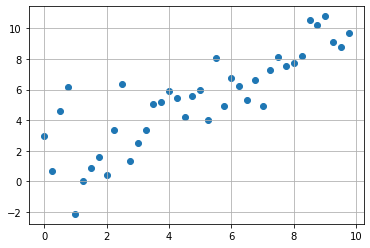

In [7]:
%matplotlib inline
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
from numpy.random import normal, seed
import sklearn.linear_model as slm
from sklearn.preprocessing import scale
import sklearn.model_selection as ms
from math import sqrt
import tensorflow as tf
import tensorflow.keras as keras
import keras.models as models
import keras.layers as layers
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from keras import optimizers
from tensorflow.keras import regularizers
#from keras import regularizationregularizers
#from keras.layers.normalization import BatchNormalization

seed(34567)
x = np.arange(start = 0.0, stop = 10.0, step = 0.25) 
y = np.add(x, normal(scale = 2.0, size = x.shape[0]))

plt.scatter(x,y)
plt.grid()

Notice that thees data points fall approximately on a straight line, but with significant deviations. 

Next, we will compute a simple single regression model. This model has an intercept term and a single slope parameter. The code in the cell below splits the data into randomly selected training and testing subsets. Execute this code.

In [2]:
indx = range(len(x))
seed(9988)
indx = ms.train_test_split(indx, test_size = 20)
x_train = np.ravel(x[indx[0]])
y_train = np.ravel(y[indx[0]])
x_test = np.ravel(x[indx[1]])
y_test = np.ravel(y[indx[1]])

Next, we will use the linear model in `sklearn.linear_model` package to create a single regression model for these data. The code in the cell below does just this, prints the single model coefficient, and plots the result. Execute this code. 

***
> **Note:** you can find documentation along with some examples of scikit-learn regression models on the [regression models pages](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
***

[2.18028763]


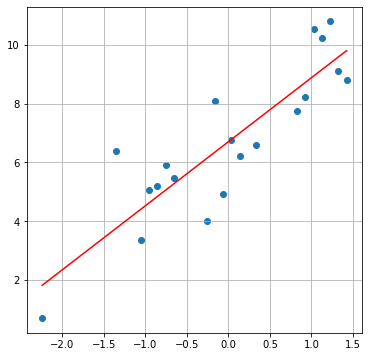

RMSE = 1.2214941652952345


In [8]:
def plot_reg(x, y_hat, y):
    ax = plt.figure(figsize=(6, 6)).gca() # define axis

    ## Get the data in plot order
    x_yhat_y = sorted(zip(x, y_hat, y))
    x = [x for x, _, _ in x_yhat_y]
    y_hat = [y_hat for _, y_hat, _ in x_yhat_y]
    y = [y for _, _, y in x_yhat_y]
    
    ## Plot the result
    plt.plot(x, y_hat, c = 'red')
    plt.scatter(x, y)
    plt.grid()
    plt.show()    
        
def reg_model(x, y):
    mod = slm.LinearRegression()
    x_scale = scale(x)  # .reshape(-1, 1)
    mod.fit(x_scale, y)
    print(mod.coef_)
    return mod, x_scale, mod.predict(x_scale)

mod, x_scale, y_hat = reg_model(x_train.reshape(-1, 1), y_train)

plot_reg(x_scale, y_hat, y_train)
print('RMSE = ' + str(np.std(y_hat - y_train)))

Examine these results. Notice that the single coefficient (slope) seems reasonable, given the standardization of the training data. Visually, the fit to the training data also looks reasonable. 

We should also test the fit to some test data. The code in the cell does just this and returns the RMS error. execute this code.

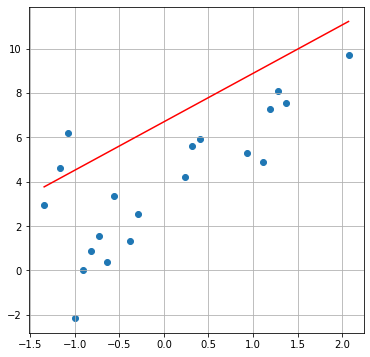

RMSE = 1.9292639905624638


In [9]:
def test_mod(x,y, mod):
    x_scale = scale(x)
    y_score = mod.predict(x_scale)
#    plot_reg(x_scale, scale(y_score), scale(y))
    plot_reg(x_scale, y_score, y)
    plt.show()
    print('RMSE = '+ str(np.std(y_score - y)))    

test_mod(x_test.reshape(-1, 1), y_test, mod)

Again, these results look reasonable. The RMSE is relatively small given the significant dispersion in these data. 

## Exercise 4-2-1

> **Exercise 4-2-1:** You will try a model with significantly higher capacity. In this case the new features are a 9th order polynomial. Using this new set of features you will train a regression model and display a summary of the results. Now do the following:    
> 1. Use the `x_scale` feature set for model training.     
> 2. Define a Scikit-Learn [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object named `mod_power`.   
> 3. Apply the `fit` method to the linear regression object using the `x_scale` features and `y_train` labels.    
> 4. Apply the `predict` method to the trained model with the `x_scale` features.  
> 5. Use the `plot_reg` to display the fit of the model to the training data.  
> 6. Print the model coefficients and RMSE of the model fit. 

In [10]:
def test_mod_multi(x, features, y, mod):
    y_score = mod.predict(features)
    plot_reg(x, y_score, y)
    print('RMSE = '+ str(np.std(y_score - y)))

seed(2233)
x_power = np.power(x_train.reshape(-1, 1), range(1,10))
x_scale = scale(x_power)
print('The shape of the feature set = ' + str(x_scale.shape))

The shape of the feature set = (20, 9)


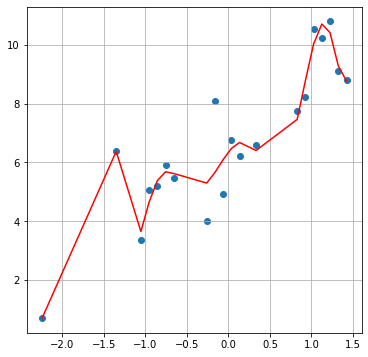

In [11]:
## Your code below
mod_power = slm.LinearRegression()
mod_power.fit(x_scale, y_train)
y_predict = mod_power.predict(x_scale)
plot_reg(x_scale[:,0], y_predict, y_train)

In [13]:
print('Model Coefficients')
print(mod_power.coef_)
print('')
print('RMSE')
print(np.std(y_predict-y_train))

Model Coefficients
[    3801.79377162   -55910.91606812   340393.61249869 -1135034.00409237
  2291726.9800196  -2884767.48280071  2217807.98182477  -954167.45880999
   176179.90380961]

RMSE
0.7329681695007354


> Examine these results and compare them to the results of the foregoing trained single feature regression model. 
> 1. Compare the graphs of the fit of the polynomial model to the single feature model. What does the difference tell you about model capacity and bias?  
> 2. Compare the training RMSE of the polynomial model to the single regression models. What does this difference tell you about training bias, and why? 
> 3. Compare the values of the model coefficients of the polynomial model with the single feature model. What does the difference in magnitudes tell you about the likely generalization? 
> **End of exercise**.

> **Answers:**
> 1.    
> 2.    
> 3.    

**- There is a wide range of coefficient values across 7 orders of magnitude. This situation is in contrast to the coefficient of the single regression model which had a reasonable single digit value.**


**- The graph of the fitted model shows highly complex behavior. In reality, this behavior indicates the model is 'learning the data'.**

Now, we will try to test the model with the held-back test data. The code in the cell below creates the same features and applies the `predict` method to the model using these test features.

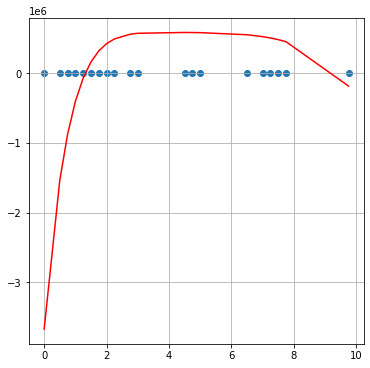

RMSE = 1005937.9132068543


In [15]:
x_test_scale = scale(x_test.reshape(-1, 1)) # Prescale to prevent numerical overflow. 
x_test_power = np.power(x_test_scale, range(1,10))
x_scale_test = scale(x_test_power)

y_predict = mod_power.predict(x_scale_test)

test_mod_multi(x_test, x_scale_test, y_test, mod_power)

This is clearly a terrible fit! Comparing the results we find:  
1. The single parameter model fits the data well and generalizes while the high capacity polynomial model clearly does not, with large deviations from the test values.      
2. The small RMSE of the single feature model indicates in will mostly likely generalize, whereas the RMSE of the polynomial model orders of magnitude larger, indicating very poor generalization.

## 2.0 l2 regularization

We will now explore one of the mostly widely used regularization methods, often referred to as l2 regularization. 

The same method goes by some other names, as it has been 'invented' several times. In particular this method is known as, **Tikhonov regularization**, **l2 norm regularization**, **pre-whitening** in engineering, and for linear models **ridge regression**. In all likelihood the method was first developed by the Russian mathematician Andrey Tikhonov in the late 1940's. His work was not widely known in the West since his short book on the subject, [Solution of Ill-Posed Problems](https://www.researchgate.net/publication/44438630_Solutions_of_ill-posed_problems_Andrey_N_Tikhonov_and_Vasiliy_Y_Arsenin), was only published in English in 1977, about 30 years after it had appeared in Russian.

![](img/Tikhonov_board.jpg)
<center> **Figure 2.1   
Commemorative plaque for Andrey Nikolayevich Tikhonov at Moscow State University**


So, what is the basic idea? l2 regularization applies a **penalty** proportional to the **l2** or **Euclidean norm** of the model weights to the loss function. The total loss function then becomes:  

$$J(W) = J_{MLE}(W) + \lambda ||W||^2$$

Where,

$$||W||^2 = \big( w_1^2 + w_2^2 + \ldots + w_n^2 \big)^{\frac{1}{2}} = \Big( \sum_{i=1}^n w_i^2 \Big)^{\frac{1}{2}}$$

We call $||W||^2$ the l2 norm of the weights since we square the power of the weights, sum, and then take the square root, or $\frac{1}{2}$ power. 

You can think of this penalty as constraining the 12 or Euclidean norm of the model weight vector. The value of the hyperparameter $\lambda$ determines how much the norm of the coefficient vector constrains the solution. You can see a view of this geometric interpretation in Figure 2.2 below.  

![](img/L2.jpg)
<center> **Figure 2.2. Geometric view of l2 regularization**

Notice that for a constant value of l2, the values of the model parameters $B1$ and $B2$ are related. For example, if $B1$ is maximized then $B2 \sim 0$, or vice versa. It is important to note that l2 regularization is a **soft constraint**. Coefficients are driven close to, but likely not exactly to, zero.   

****
**What is the difference between the L2 norm and l2 norm?**  Notice that we are discussing the l2 norm with a lower case 'l'. You will often find discussion of the L2 norm with an upper case 'L', or where the l2 and L2 notation are used interchangeably. In practice the difference can be subtle and is often ignored. 

We have already defined the l2 norm as the square root of the sum of the squares of a discrete variable (e.g. a set of weight values). Strictly speaking the L2 norm is the equivalent metric for a continuous function. For example, we can write express the L2 norm of a continuous function $\phi(x)$ as: 

$$||\phi(x)||^2 = \langle \phi(x), \phi(x) \rangle = \int \phi(x)^2 dx$$
****

### 2.1 The eigenvalue penalty interpretation

To develop deeper understanding of l2 regularization we look at the eigenvalue-eigenvector decomposition for a linear model. While neural networks are clearly nonlinear, the behavior is approximately linear locally, particularly near a minimum of the loss function.    

### 2.1.1 Review of Eigenvalue Decomposition

**Eigenvalues** are characteristic roots or characteristic values of a linear system of equations. The **eigenvalue-eigenvector** decomposition is a factorization of the a matrix. 

Let's start with a **square matrix**, $A$:

$$A = 
\begin{bmatrix}
   a_{11}  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn}
\end{bmatrix}$$

Next define a vector, $x$: 

$$x = 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}$$

Then an **eigenvalue** of the matrix $A$ has the property: 

$$A x = \lambda x$$

Or,   

$$
\begin{bmatrix}
   a_{11}  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn}
\end{bmatrix}  
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix} 
= 
\lambda 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}
$$



To see that the eigenvalue, $\lambda$, is a root of the matrix, $A$ we can rearrange the above as follows:   

\begin{align}
Ax - \lambda x &= 0 \\
(A - I \lambda) x &= 0
\end{align}

Where, $I$ is the **identity matrix** of 1 on the diagonal and 0 elsewhere. These relationships can be written as follows:  

$$
\begin{bmatrix}
   a_{11} - \lambda  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} - \lambda  & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn} - \lambda 
\end{bmatrix}  
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix} 
= 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}
$$


The foregoing show that the eigenvalue, $\lambda$, is a root of the matrix, $A$. Further, notice that the eigin 

For an $n\ x\ n$ matrix, $A$, there are $n$ eigenvalues or roots. These can be found by solving the following equation, using the determinant:  

$$det(A - x) = 0$$

You can find more information on the determinant in this [article](https://en.wikipedia.org/wiki/Determinant).

### Eigenvalues and Eigenvectors

There are special vectors, known as an **eigenvectors**, associated with each eigenvalue of a square matrix, $A$. There is, in fact, a left and right eigenvector for each eigenvalue. 

Let's start with a **right eigenvector** which has the property: 

\begin{align}
 A x_r &= \lambda_r x_r\\
(A - I \lambda_r)x_r &= 0
\end{align}

Notice that the right eigenvector, $\lambda_r$, is to the right of the matrix, $A$, giving rise to the name.   

The relationship for the **left eigenvector** is a bit more complicated, To get the same result as shown for the right eigenvector it is necessary to take a transpose of the system of equations: 

\begin{align}
x_l A  &= \lambda_l x_l\\
(x_l A)^T  &= \lambda_l x_l^T\\
(A^T - I \lambda_l)x_l^T &= 0
\end{align}

For the above relationships to hold, the eigenvectors must have unit l2 norm:

$$||x||^2 = (x_{1}^2 + x_{2}^2 \ldots x_{n}^2)^{1/2} = 1$$

Using the above relationships we can factor a square $n\ x\ n$ matrix, $A$ into eigenvectors and eigenvalues. Representing the matrix of eigenvectors as $Q$ and the diagonal matrix of n eigenvalues as $\Lambda$:

$$A = Q \Lambda Q^{-1}$$

Where $Q^{-1}$ is the inverse of the eigenvector matrix. Since the eigenvectors have norm 1, the eigenvector matrices, $Q$ are then **unitary**.  

Using the eigenvalue-eigenvector decompositions, the inverse of a square $n\ x\ n$ matrix can be expressed:

$$A^{-1} = Q \Lambda^{-1} Q^{-1}$$  

In fact, since the matrix of eigenvectors is unitary, we can compute the value of the matrix $A$ to the Nth power as:

$$A^{N} = Q \Lambda^{N} Q^{-1}$$

You can find more information on the properties of eigenvalue-eigenvector decomposition in this [article](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix).

### 2.1.3 Eigenvalues and the Normal Equations

Let's start by examining the **normal equation** formulation of the linear regression problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ and a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

The commonly used normal equation form can help with this problem:

$$b = (A^TA)^{-1}A^Tx$$

Now, $A^TA$ is a symmetric $m x m$ covariance matrix, where $m$ is the number of model coefficients. This is a significant reduction in size when compared to $A$. 

Now, we can perform eigenvalue-eigenvector decomposition of $A^TA$:

$$A^TA = Q \Lambda Q^{-1}$$

Where,
$Q = $ unitary matrix of orthonormal **eigenvectors**, and
$\Lambda =$ diagonal matrix of **eigenvalues**. The eigenvalue matrix is diagonal:  

$$\Lambda = 
\begin{bmatrix}
    \lambda_1  & 0 & 0 & \dots & 0 \\
    0  & \lambda_2 & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \lambda_n
\end{bmatrix}$$


Since Q is unitary (unit norm), the inverse of $A^TA$ is easily computed:

$$(A^TA)^{-1} = Q \Lambda^{-1} Q^{-1}$$

Where,
$$\Lambda^{-1} = 
\begin{bmatrix}
    \frac{1}{\lambda_1}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{\lambda_2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{\lambda_n}
\end{bmatrix}$$
and $\lambda_i$ is the ith eigenvalue. 

But, **$A^TA$ can still be rank deficient!** By rank deficient we mean that there are fewer non-zero eigenvalues of $A^TA$ than the dimension, $n$. Even is the ith eigenvalue is close to zero, $\frac{1}{\lambda_i}$ becomes very large and destabilizes the inverse. 

The basic idea of $l_2$ regularization, Tikhonov regularization, or ridge regression is to stabilize the inverse eigenvalue matrix,$\Lambda$, by **adding a small bias term**, $\alpha$, to each of the eigenvalues. We can write this operation in matrix notation as follows. We start with a modified form of the normal equations (also know as the **L2 or Euclidean norm** minimization problem):

$$min [\parallel A \cdot x - b \parallel + \parallel \alpha^2 \cdot I \parallel]\\  or \\
b = (A^TA + \alpha^2 \cdot I)^{-1}A^Tx$$

In this way, the inverse values of small eigenvalues do not blow up when we compute the inverse. You can see this by writing out the $\Lambda^+$ matrix with the bias term.

$$\Lambda_{Tikhonov}^+  = \begin{bmatrix}
    \frac{1}{\lambda_1 + \alpha^2}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{\lambda_2 + \alpha^2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{\lambda_m + \alpha^2}
\end{bmatrix}$$

Adding this bias term ensures there are no non-zero eigenvalues, and that the inverse of $A^TA$ exists. You can also see that added the bias term adds a 'ridge' along the diagonal of the eigenvalue matrix, giving this method one of its names. 

### 2.3 Eigenvalues of the model matrix

The foregoing is a bit abstract. To build some intuition you will now investigate the behavior of the eigenvalues for an unregularized and regularized model matrix.   

The convergence properties of a linear model can be summarized by the **condition number**, $C = \frac{abs(largest\ eigenvalue)}{abs(smallest\ eigenvalue)}$. Generally, a model matrix with a condition number of less than a few hundred is considered to have good convergence properties. Models with poor convergence properties are unlikely to generalize well. 

## Exercise 4-2-2

> **Exercise 4-2-2:** For this exercise you will continue working with the model matrix of the running examples, `x_scale`. You will first investigate the eigenvalues of the unregularized model matrix. Then you will apply regularization to the model matrix and investigate the changes in the eigenvalue. Now do the following:   
> 1. Compute the (**real part** of the **unnormaized**) covariance matrix using [numpy.transpose](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html) and [numpy.matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html).
> 2. Compute the eigenvalues of the covariance matrix using (numpy.linalg.eigvals)[https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigvals.html]. 
> 3. Print the eigenvalue vector.  
> 4. Log base 10 transform the eigenvalues using (numpy.log10)[https://numpy.org/doc/stable/reference/generated/numpy.log10.html] and plot them vs the number. The eigenvalues are in numbered order. 

In [ ]:
def plot_eigs(eig_vals):
    fig, ax = plt.subplots(figsize=(8,8))
    x_vals = [x + 1 for x in range(len(eig_vals))]
    ax.plot(x_vals, np.log10(eig_vals));
    ax.set_xlabel('eigenvalue number');
    ax.set_ylabel('log eigenvalue');
    ax.set_title('eigenvalue vs. number');

In [ ]:
## Your code below


> 5. Execute the code in the cell below to create a matrix with the regularization or bias term on the diagonal.

In [ ]:
diag_reg = np.zeros((covariance.shape), float)
np.fill_diagonal(diag_reg, 1.0)
diag_reg

> 6. To create a regularized covariance matrix, add the covariance matrix to the `diag_reg` matrix.  
> 7. Compute and print the eigenvalues of the regularized covariance matrix.  
> 8. Plot the log base 10 eigenvalues of the regularized covariance matrix.  

In [ ]:
## Your code goes here





> Answer the following questions:   
> 1. Examine the eigenvalues of the unregularized model matrix. Taking advantage of the fact that eigenvalues are presented descending order, what is the approximate condition number of the scaled model matrix, what does this tell you about the convergence properties of the model and its generalization properties?   
> 2. Examine the eigenvalues of the regularized model matrix. What is the approximate condition number of the regularized model matrix, what does this tell you about the convergence properties of the model and its generalization properties? 
> 3. Notice that the eigenvalues of the regularized model converge to the value of the regularization coefficient as the eigenvalue number increases. Eigenvalues of about the value of the regularization coefficient may add small amounts of bias to the model predictions but cannot provide any predictive information. Given this consideration, what is the equivalent number of informative features? Note that these 'features' are projections into the eigenspace, not actual columns of the model matrix.  
> **End of exercise**.

> **Answers:**
> 1.  
> 2.    
> 3.    

### 2.4 Regularization for regression  

Let's go back to our regression example. Recall that the 9th order polynomial regression model was massively over-fit. Can l2 regularization help this situation? We can create a model applying regularization and find out. 

## Exercise 4-2-3:

> **Exercise 4-2-3:** You will now create and test code for an l2 regularized, or ridge, regression model in the cell below using the [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) model from sklearn.linear_model. The Ridge model has an argument `alpha` which corresponds to the regularization parameter, in the notation we have been using. Now, do the following:    
> 1. Define a ridge regression model object named, `mod_L2`, with `alpha=1.0` as the L2 regularization parameter.  
> 2. Fit the ridge regression model with the same features and labels used previously.  
> 3. Apply the predict method using the feature data as the argument. 
> 5. Use the `plot_reg` to display the fit of the model to the training data.  
> 6. Print the model coefficients and RMSE of the model fit. 

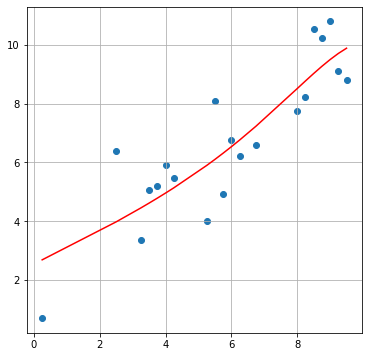

In [17]:
## Your code below
mod_L2 = slm.Ridge(alpha = 1.0)
mod_L2.fit(x_scale, y_train)
y_predic_L2 = mod_L2.predict(x_scale)    

#Plot
plot_reg(x_train, y_predic_L2, y_train)

In [18]:
print('Model Coefficients')
print(mod_L2.coef_)
print('')
print('RMSE')
print(np.std(y_predic_L2 - y_train))

Model Coefficients
[ 1.35924056  0.30472335  0.21513283  0.2553236   0.25085494  0.17711915
  0.04339031 -0.13528087 -0.34506222]

RMSE
1.2240592438232802


> Compare the results for this model to the un-regularized one trained previously and answer the following questions:   
> 1. Compare the graphs of the training data fit and RMSE for the regularized and un-regularized models. How can you explain these differences and what do these differences imply for training bias and generalization of the model.     
> 2. Compare the magnitudes of the model coefficients between the regularized and un-regularized models. Do these differences account for the different behavior of the regularized and un-regularized models and why?   

> **End of exercise**. 

> **Answers:**  
> 1.     
> 2.     

**This model is quite different from the un-regularized one we trained previously.** 

**- The coefficients all have small values. Some of the coefficients are significantly less than 1. These small coefficients are a direct result of the l2 penalty.**

**- The fitted curve looks rather reasonable given the noisy data.**


Let's test the model on the test data. Execute the code in the cell below and examine the results. 

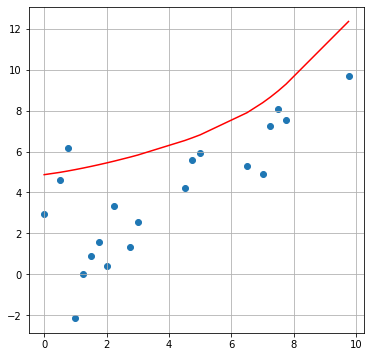

RMSE = 1.9160891445046224


In [19]:
test_mod_multi(x_test, x_scale_test, y_test, mod_L2)

This result looks a lot more reasonable than for the un-regularized model. The l2 regularization significantly improves the variance and therefore generalization of the model. The lower variance is evident from the smooth fit curve and lower RMSE of the regularized model. The bias from the regularization is noticeable in the fit to the test data. This behavior is consistent with the constrained parameter values and higher bias but lower variance from the L2 regularization. 

### 2.5 l2 regularization for deep learning models 

So, you may well wonder, how well l2 regularization applies to deep neural networks? Let's give it a try using the 9th order polynomial data.  

The code in the cell below defines and fits regression model with a single hidden layer with 128 units. No regularization is applied in this first model. Execute the code and view the model summary. 

In [20]:
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                  epochs = 100, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                   verbose = 0)

In [21]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


With the model fit, let's have a look at the loss function vs. training epoch. Execute the code in the cell below and examine the result. 

In [24]:
def plot_nn_fit(x, y, mod):
    predicted = mod.predict(x)
    plot_reg(x[:,0], predicted, y)
    print('RMSE = ' + str(np.std(predicted - y)))
    
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color='red', label='Test loss')
    plt.plot(x, train_loss, color='blue', label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.grid()
    plt.show()

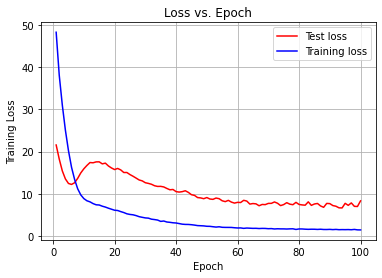

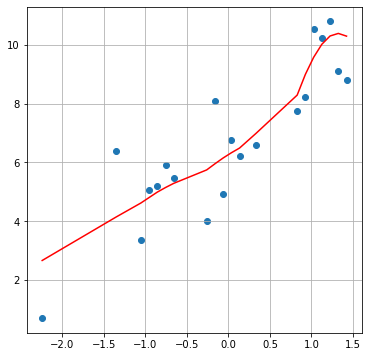

RMSE = 3.4017709732636945


In [25]:
plot_loss(history) 
plot_nn_fit(x_scale, y_train, nn)

The training and test loss improves for quite a few epochs. 

Execute the code in the cell below to compute and plot predictions for the unconstrained model. 

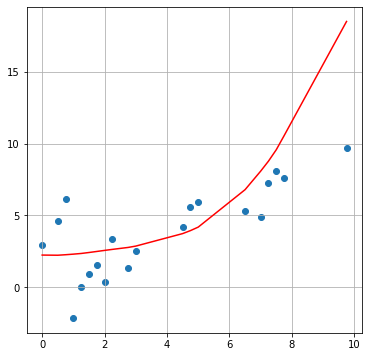

RMSE = 5.07519271255298


In [26]:
test_mod_multi(x_test, x_scale_test, y_test, nn)

Now, we will try to improve this result by applying l2 norm regularization to the neural network. The code in cell below adds l2 regularization to the model. Execute the code and examine the results.

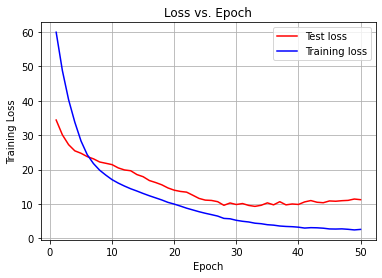

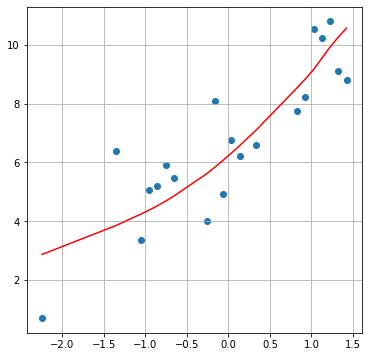

RMSE = 3.4239326648359727


In [27]:
nn_L2 = models.Sequential()
nn_L2.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(1.0)))
nn_L2.add(layers.Dense(1))
nn_L2.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn_L2.fit(x_scale, y_train, 
                  epochs = 50, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)

plot_loss(history)
plot_nn_fit(x_scale, y_train, nn_L2)

But are the predictions any better? Execute the code in the cell below and find out. 

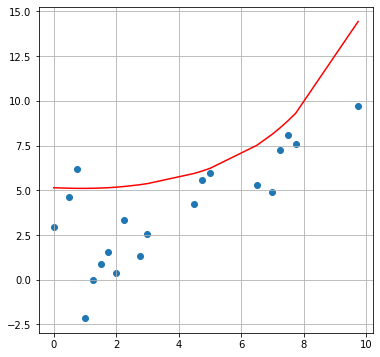

RMSE = 3.768439531314096


In [28]:
test_mod_multi(x_test, x_scale_test, y_test, nn_L2)

Examine and compare the results for the regularized and un-regularizzed neural network models and the regularized linear model. The linear model has the lowest capacity and the lowest variance. The highest capacity model is the un-regularized neural network model which has the highest variance and a test fit curve that deviates significantly from the values, but shows low systematic bias. The regularized neural network model has intermediate capacity and variance. The bias of the regularized neural network model can be seen in the fit to the test data.      

## 3.0 l1 regularization

We can also do regularization using other norms. The **l1 regularization** or **Lasso**  method limits the sum of the absolute values of the model coefficients. The l1 norm is sometime know as the **Manhattan norm**, since distance are measured as if you were traveling on a rectangular grid of streets. This is in contrast to the l2 norm that measures distance 'as the crow flies'. 

We can compute the l1 norm of the weights as follows:

$$||W||^1 = \big( |w_1| + |w_2| + \ldots + |w_n| \big) = \Big( \sum_{i=1}^n |w_i| \Big)^1$$

where $|x|$ is the absolute value of $x$. 

Notice that to compute the l1 norm, we raise the sum of the absolute values to the first power.

As with l2 regularization, in l1 regularization  we use a penalty term of the l1 norm of the weights. A penalty multiplier, $\alpha$, determines how much the norm of the coefficient vector constrains values of the weights. The complete loss function then becomes: 

$$J(W) = J_{MLE}(W) + \alpha ||W||^1$$

You can see a view of this geometric interpretation in Figure 3.1 below.  

![](img/L1.jpg)
<center> Geometric view of L1 regularization </center>

Notice that in Figure 3.1 if $B1 = 0$ then $B2$ has a value at the limit, or vice versa. In other words, using a l1 norm constraint forces some weight values to zero to allow other coefficients to take correct values. In this way, the l1 norm constraint **knocks out** some weights from the model altogether. In contrast to l2 regularization, l1 regularization will drive some coefficients to exactly zero. As a result, L1 optimization typically leads to **sparse models** which generalize well. 

### 3.1 l1 regularization example

With these ideas in mind, let's apply l1 norm regularization to the 9th order polynomial regression problem. The code in cell below applies l1 regularized or [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) regularization to the linear regression problem. Execute this code and examine the results. 

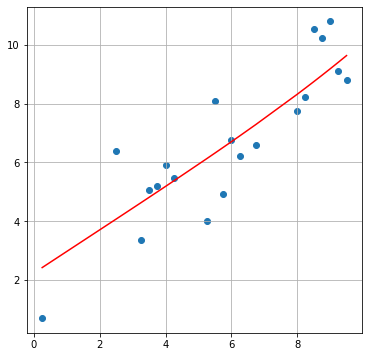

In [31]:
mod_L1 = slm.Lasso(alpha = 0.2, max_iter=100000)
mod_L1.fit(x_scale, y_train)
y_predic_L1 = mod_L1.predict(x_scale)

plot_reg(x_train, y_predic_L1, y_train)

In [32]:
print('Model Coefficients')
print(mod_L1.coef_)
print('')
print('RMSE')
print(np.std(y_predic_L1 - y_train))

Model Coefficients
[1.85254516 0.         0.         0.12691421 0.01566206 0.
 0.         0.         0.        ]

RMSE
1.2337315291986566


Now, execute the code in the cell below and examine the prediction results. 

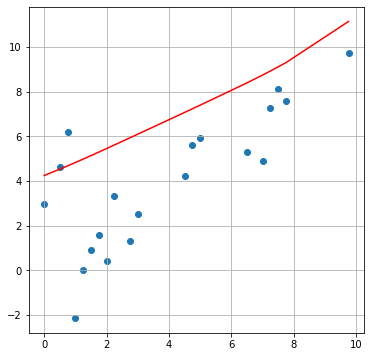

RMSE = 1.9367128130723688


In [33]:
test_mod_multi(x_test, x_scale_test, y_test, mod_L1)

## Exercise 4-2-4

> **Exercise 4-2-4:** Compare these results to those of the L2 regularized model and answer these questions:  
> 1. In terms of the bias and variance, do the L1 and L2 regularized models differ significantly, and why?    
> 2. Compare the magnitudes of the coefficients of the L1 an L2 models. WHat do the differences of these values tell you about the different behavior of these models, and why?  


> **Answers:** 
> 1.     
> 2.    

Notice the following about the results of this l1 regularized regression:
- Many of the coefficients are 0, as expected.
- The fitted curve looks reasonable. 

### 3.2 Neural network with l1 regularization

Now, we will try l1 regularization with a neural network. The code in the cell below defines, fits and plots a single layer neural network using l1 regularization. Execute this code and examine the results.

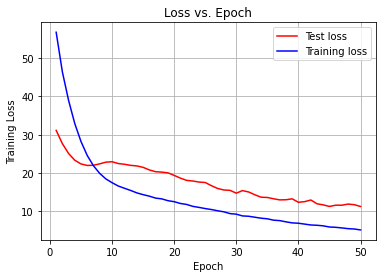

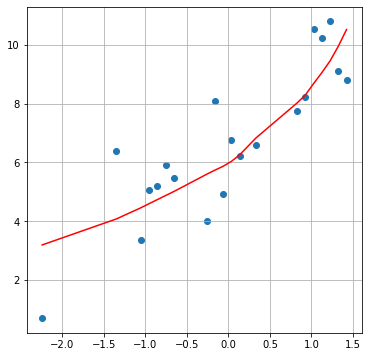

RMSE = 3.2675800604394576


In [34]:
nn_L1 = models.Sequential()
nn_L1.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l1(0.1)))
nn_L1.add(layers.Dense(1))
nn_L1.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn_L1.fit(x_scale, y_train, 
                  epochs = 50, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
plot_loss(history)
plot_nn_fit(x_scale, y_train, nn_L1)

Next, Execute the code in the cell below to compute and display predicted values from the trained network. 

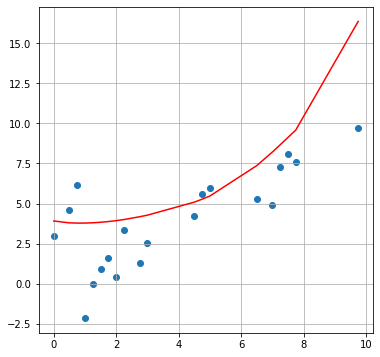

RMSE = 4.3176933148462595


In [35]:
test_mod_multi(x_test, x_scale_test, y_test, nn_L1)

Compare these results to the L2 regularized model. The fits produced by the two regularization methods are fairly similar in terms of both RMSE and fit curve. The simple nature of this regression problem may account for the lack of difference.    

## 4.0 Early stopping

Early stopping is conceptually simple. Early stopping terminates the training of the neural network model at an epoch before it becomes terribly over-fit. That's it! That is the idea of early stopping.

In fact, we have already been using early stopping as we create and test the foregoing regularized models. The question here is, how do we automate this process? 

### 4.1 Early stopping algorithm

The early stopping algorithm simple. This pseudo code shows the basic loop for early stopping on first epoch with a lower performance metric, which is executed after the first training epoch of the model. 

`Do while TRUE:  
    store current model parameters   
    update model for epoch  
    if(performance_for_epoch < stored_performance_metric)  
        return stored_model  
    else  
        stored_performance_metric = performance_for_epoch   
        store_model = model  
`  



### 4.2 How does early stopping work?

Early stopping terminates model learning before over-fitting occurs. But how can we interpret this action in terms of the loss function $J(W)_{MLE}$? Figure 4.1 below provides some insight.   

![](Figures/EarlyStopping.JPG)
<center>**Figure 4.1 Effect of early stopping on $$J(W)_{MLE}$$**</center>

On the left side of the diagram you can see contours of the weight norm. On the right are contours  Early stopping terminates training at some model weight norm $||W||^2$. Ideally this is at the point where the training of $J(W)_{MLE}$ starts to over-fit. Thus, we can think of early stopping as analogous to l2 norm regularization where we write the loss function as:

$$argmin_W J(W) = J(W)_{MLE} + \alpha ||W||^2$$

where,

$\alpha = $ a regularization parameter controlling the stopping point. 

### 4.3 Early stopping example

Manually applying early stopping is both computationally inefficient and rather tedious. Fortunately, Keras has a build in capability that allows automation. 

To implement this early stopping we need to define 2 Keras **callbacks**. Two such callbacks are required:
1. The first callback, **EarlyStopping**, is for the early stopping method.
2. The second call back **checkpoints** or saves the current model. 

These callbacks are defined in the form of a **callbacks list**. 

Notice that the model defined includes l2 regularization. Thus, this model should replicate the performance observed with manual early stopping. To see how this works, examine and then execute the code in the following cell.

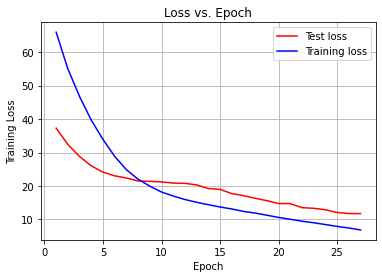

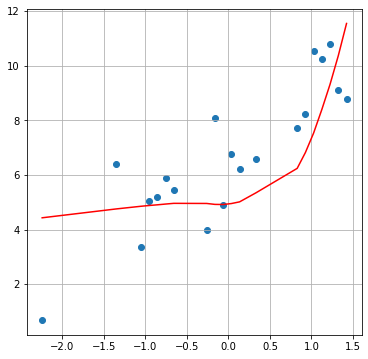

RMSE = 3.2374235190782708


In [36]:
## First define and compile a model. 
nn_ES = models.Sequential()
nn_ES.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(1.0)))
nn_ES.add(layers.Dense(1))

nn_ES.compile(optimizer = 'RMSprop', loss = 'mse', metrics = ['mse'])

## Define the callback list
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 1 # Stop after one step with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]

## Now fit the model
history = nn_ES.fit(x_scale, y_train, 
                  epochs = 100, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)
plot_nn_fit(x_scale, y_train, nn_ES)

You can see the behavior of the loss with training epoch is behaving as with l2 regularization alone. Notice that the training has been automatically terminated at the point the loss function is at its optimum. 

Let's also have a look that the accuracy vs. epoch. Execute the code in the cell below and examine the result. 

In [39]:
def plot_accuracy(history):
    train_acc = history.history['mse']
    test_acc = history.history['val_mse']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color='red', label='Test error')
    plt.plot(x, train_acc, color='blue', label='Training error')
    plt.xlabel('Epoch')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs. Epoch')  
    plt.legend()
    plt.grid()
    plt.show()

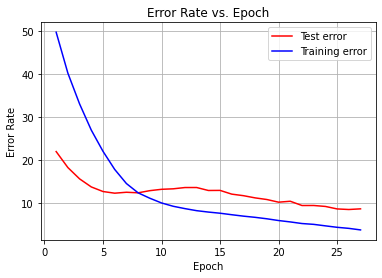

In [40]:
plot_accuracy(history)  

The curve of test accuracy is consistent with the test loss.

The code in the cell below retrieves the best model (by our stopping criteria) from storage, computes predictions and displays the result. Execute this code and examine the results. 

> **Note:** You may see a warning about a retracing (on the TensorFlow computation graph). This warning may not actually be correct. These is no known resolution and you can see from the [tread in GitHub](https://github.com/tensorflow/tensorflow/issues/34025). 

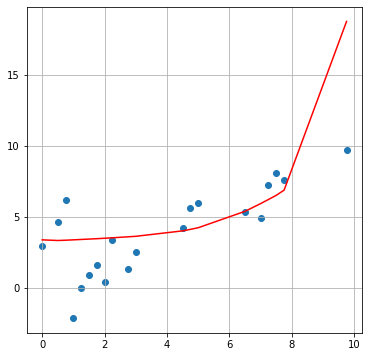

RMSE = 4.511033392700209


In [41]:
best_model = keras.models.load_model(filepath)
test_mod_multi(x_test, x_scale_test, y_test, best_model)

As expected, these results are similar, but a bit worse, than those obtained while manually stopping the training of the l2 regularized neural network.  

## 5.0 Dropout regularization

All of the regularization methods we have discussed so far, originated long before the current deep neural network era. We will now look at the **dropout regularization** method. Of all widely used regularization methods, dropout is the only one specifically developed for neural networks. The seminal paper, [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting by Srivastava et. al](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf), 2014, is quite readable and provides a lot more detail than is presented here.

We have already seen how l1 norm regularization knocks out some model weights. The **dropout method** method regularizes neural networks by creating an **ensemble** of networks with some fraction $p \lt 1.0$ of the hidden units removed. Ensemble methods are know to be strong regularizers and produce superior results by combining the learning of multiple **weak learners**. 

The dropout method is somewhat different from other ensemble methods, such as bagging. This reweighting scheme has several advantages:
- The model weights for the resulting network are reweighted by the probabilities they are sampled in the various networks of the ensemble. 
- The memory required to train the model is simply $O(n)$, where n is the number of weights. A bagged model requires  $O(M*n)$, where $M$ is the number of models in the ensemble.
- When making predictions in production only one model is used. Whereas, the predictions for each model in the bag must be computed for bagging. 

To understand this method, let's recall the basic model for a the output of a lth layer in a fully connected network:

$$z^{(l+1)}_i = w^{(l+1)}_i \cdot h^{(l)} + b^{(l+1)}_i\\
h^{(l+1)}_i = \sigma(z^{(l+1)}_i)$$

where:

$\sigma = $ the activation function. 

Now, we need to sample the hidden units with probability $p$, in which case we can write:

$$r^{(l)}_i \sim Bernoulli(p)\\
\tilde{h}^{(l)}_i = r^{(l)}_i * y^{(l)}\\
z^{(l+1)}_i = w^{(l+1)}_i \cdot \tilde{h}^{(l)}_i + b^{(l+1)}_i\\
h^{(l+1)}_i = \sigma(z^{(l+1)}_i)$$

where:

$r^{(l)}_i =$dropout vector with values $\{0,1\}$.

To get a feel for what this means in practice examine Figure 5.1. This figure shows a fully connected network with 4 hidden units and a dropout probability $p = 0.5$. 

![](Figures/DropoutExample.JPG)
![](Figures/DropoutExample2.JPG)

<center>Figure 5.1   
Some possible dropouts for a simple fully connected network with p = 0.5</center>

Examine Figure 5.1 and notice the following:

- There are 6 ways to achieve dropout with exactly 1/2 the units as shown. 
- No units might dropout with probability $p^4$. 
- A single unit might drop out with probability $p^3 (1-p)$. 
- All units might drop out with probability $(1-p)^4$. This case is not admissible so should not be sampled. 

In fact there are $n^2$ possible dropout patterns for a hidden layer with n units. This scaling quickly leads to a problem. For any realistic size network, it is not possible fully sample all of the possibilities. Instead, we need to use some kind of approximation with a reasonable number of samples. 

Ideally, we want a model that gives us the posterior probability of $y$, the output, given $x$ the input which we can write $p(y\ |\ x)$. If we had infinite computing resources we could Monte Carlo sample this distribution for our neural network. This ideal reference neural network is known as **Bayesian network**. Clearly, for large scale networks it is not possible to compute this result.   

We have to settle for a sampled result. We reweight by the probability that a sample is created. Continuing with the notation we used before we can write:

$$p(y\ |\ x) \sim \sum_r p(r) p(y\ |\ x, r)$$

where,

$r = $ the Bernoulli sampled mask vector. 

Given enough samples the approximation above will converge to the desired probability distribution. However, in practice it has been found that the **geometric mean** of the ensemble converges faster. 

### Backpropagation with dropout regularization

Some elements of the weight tensor are dropped out of the model at each step of dropout regularization. Given this, how can the partial derivatives required for backpropagation be computed? 

Recall the dropout algorithm:  

$$r^{(l)}_i \sim Bernoulli(p)\\
\tilde{h}^{(l)}_i = r^{(l)}_i * y^{(l)}\\
z^{(l+1)}_i = w^{(l+1)}_i \cdot \tilde{h}^{(l)}_i + b^{(l+1)}_i\\
h^{(l+1)}_i = \sigma(z^{(l+1)}_i)$$

where:

$r^{(l)}_i =$dropout vector with values $\{0,1\}$.

There are two cases here:
- $r^{(l)}_i = 1$, in which case the partial derivative = 1.
- $r^{(l)}_i = 0$, in which case the partial derivatives = 0.

### 5.1 Computing a neural network with dropout regularization

With a bit of theory in mind, we will now apply dropout regularization to training a neural network. The code in the cell below defines a neural network with a dropout layer with $p =0.5$. The rest of this network is identical to other networks we have been working with. Execute this code and examine the result. 

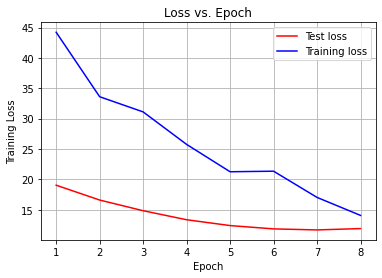

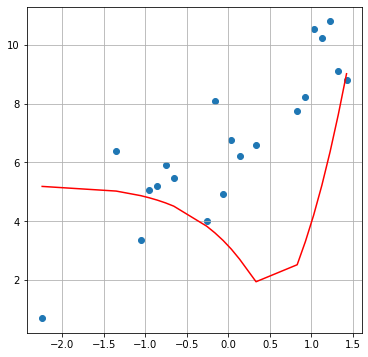

RMSE = 3.001319032359001


In [42]:
## First define and compile a model with a dropout layer. 
nn_DO = models.Sequential()
nn_DO.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn_DO.add(Dropout(0.5)) # Use 50% dropout on this model
nn_DO.add(layers.Dense(1))
nn_DO.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mse'])

## Now fit the model
history = nn_DO.fit(x_scale, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)
plot_nn_fit(x_scale, y_train, nn_DO)

The familiar loss plot looks a bit different here. Notice the kinks in the training loss curve. THis is likely a result of the dropout sampling. 

Execute the code in the cell below and examine the accuracy vs. epoch curves. 

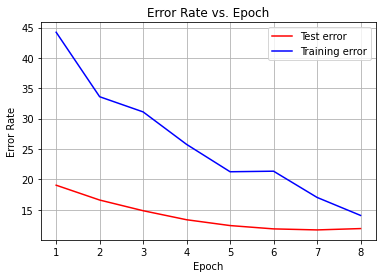

In [43]:
plot_accuracy(history)

The behavior of the training accuracy curve has a similar appearance to the loss curve in terms of the jagged appearance. 

Execute the code in the cell below examine the prediction results for this model. 

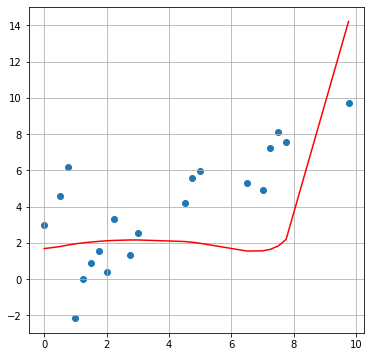

RMSE = 4.023859308789681


In [44]:
best_model = keras.models.load_model(filepath)
test_mod_multi(x_test, x_scale_test, y_test, best_model)

These results appear similar to those obtained with other regularization methods for neural networks on this problem. While the dropout method is an effective regularizer it is no 'silver bullet'. 

## 6.0 Batch Normalization

It is often the case that the distribution of output values of some hidden layers changes . The result is that propagated gradients can become near zero, significantly slowing convergence in many cases. We will discuss this **vanishing gradient problem** in another lesson.  

In 2015, [Sergey and Szegedy](https://arxiv.org/pdf/1502.03167.pdf) introduced a solution to this problem with their paper **Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift**. The basic idea is simple. A batch normalization layer maintains an exponential moving average estimate of the mean and variance of the outputs of learn. These values are used to normalize the output values of the preceding layer. In other words, the batch normalization layer ensures the distribution of the output values are constant. 

Let's try an example. The simple neural network model defined in the code cell below includes a batch normalization layer. Also notice that to improve convergence the early stopping has been modified to have a patience of 3. Execute this code.      

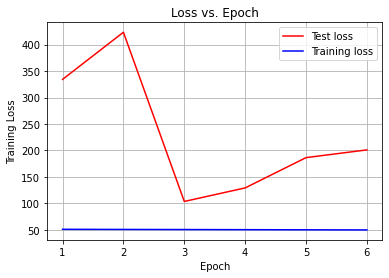

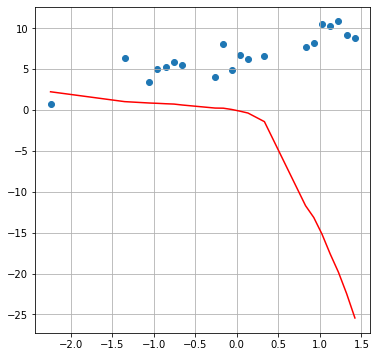

RMSE = 9.518881060095195


In [45]:
## Use patience of 3
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 3 # Stop after one step with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]

## Now, define an NN model using batch normalization. 
## First define and compile a model with a batch normalization layer. 
nn_BN = models.Sequential()

## Fully connected layers with droppout regularization only
nn_BN.add(layers.Dense(128, input_shape=(9, )))
nn_BN.add(LeakyReLU(alpha=0.2))
nn_BN.add(layers.Dense(128)) 
nn_BN.add(BatchNormalization(momentum = 0.1))
nn_BN.add(LeakyReLU(alpha=0.2))

nn_BN.add(layers.Dense(1))
## Define the optimizer and compile
optm = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
nn_BN.compile(optimizer = optm, loss = 'mse', metrics = ['mse'])

## Now fit the model
history = nn_BN.fit(x_scale, y_train, 
                  epochs = 100, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)
plot_nn_fit(x_scale, y_train, nn_BN)

The loss decreases rapidly and then remains in a narrow range thereafter. It appears that convergence is quite rapid.

How does the accuracy evolve with the training episodes? Execute the code in the cell below to display the result.   

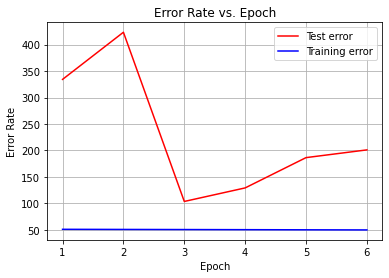

In [46]:
plot_accuracy(history)

This accuracy curve is rather unusual. It seems to reflect the simple regularization being used. 

Finally, execute the code in the cell below to evaluate the predictions made with this model. 

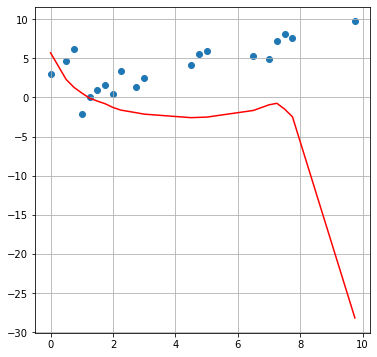

RMSE = 6.977924278968015


In [47]:
best_model = keras.models.load_model(filepath)
test_mod_multi(x_test, x_scale_test, y_test, best_model)

Despite the odd convergence properties of this model the fit to the test data is similar to that achieved with the  

## 8.0 Using multiple regularization methods

In many cases more than one regularization method is applied. We have already applied early stopping with other regularization methods. In this demonstration we will use four regularization methods at once:
- l2 regularization.
- l1 regularization.
- Early stopping. 


Examine the code in the cell below. The four regularization methods are combined. Notice that the combined L1 and L2 regularization are performed with the Keras [l1_l2](https://keras.io/api/layers/regularizers/) function, with two arguments for the L1 and L2 regularization factors.     

Execute this code and examine the results.  

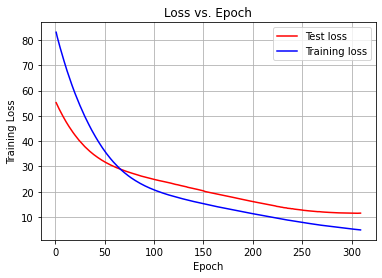

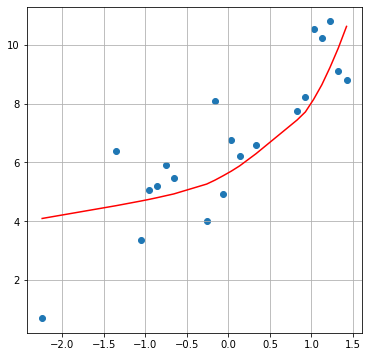

RMSE = 3.1584387739560227


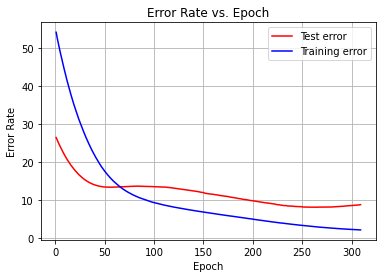

In [48]:
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 4 # Stop after one step with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]


## Define a model with regularization  
nn_MU = models.Sequential()
## Dense layer with both l1 and l2 regularization
nn_MU.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l1_l2(0.1, 1.0)))
nn_MU.add(layers.Dense(1))
optm = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
nn_MU.compile(optimizer=optm, loss = 'mse', metrics = ['mse'])

## Now fit the model
history = nn_MU.fit(x_scale, y_train, 
                  epochs = 510, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)
plot_nn_fit(x_scale, y_train, nn_MU)
plot_accuracy(history)

Finally, we can evaluate the predictions the model produces. Execute the code in the cell below and examine the result.

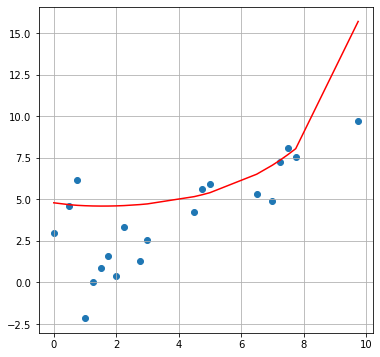

RMSE = 3.911677823536382


In [49]:
best_model = keras.models.load_model(filepath)
test_mod_multi(x_test, x_scale_test, y_test, best_model)

Compare the results from this model with the L2 and L1 regularized models. There are no substantial difference in the RMSE and the fit plots between these models, given the simple model. Compare the results from this model with the L2 and L1 regularized models. There are no substantial difference in the RMSE and the fit plots between these models, given the simple model. More subtly, the bias of the test predictions looks to be a bit lower, despite the nearly identical RMSE.   

#### Copyright 2018, 2019, 2020, 2021, 2022 Stephen F Elston. All rights reserved.